# Déployez un modèle dans le cloud version local 

Vous êtes donc chargé de développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.

Il n’est pas nécessaire d’entraîner un modèle pour le moment.

L’important est de mettre en place les premières briques de traitement qui serviront lorsqu’il faudra passer à l’échelle en termes de volume de données !



## Déroulement

Dans un premier temps, nous allons regarder plus en détail le jeu de données. 
- À la suite de cela, le projet va être réalisé en deux temps. 
 + En premier, développer et exécuter notre code en local, avec peu de données.
 + Pour finir, nous déploierons notre code dans un environnement Big Data en mode distribué. 

### Information sur le jeu de données 

ensemble de données d'images contenant des fruits et légumes

Nombre total d'images : 90 483.

Taille de l'ensemble d'entraînement : 67 692 images (un fruit ou un légume par image).

Taille de l'ensemble de test : 22 688 images (un fruit ou un légume par image).

Taille de l'ensemble multi-fruits : 103 images (plus d'un fruit (ou classe de fruits) par image)

Nombre de classes : 131 (fruits et légumes).

Taille de l'image : 100 x 100 pixels.

# Librairies

In [2]:
import os
import io
from io import StringIO

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image,ImageOps,ImageFilter
import cv2 as cv

#pyspark modules
import pyspark 
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql.functions import udf, element_at
#from pyspark.ml.image import ImageSchema
#import pyspark.sql.functions as F
#from pyspark.sql.types import ArrayType, IntegerType, FloatType, StringType

# tnesorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


## I EDA

In [3]:
for dirname, _, filenames in os.walk('../Projet_8/data'):
    for filename in filenames:
        if filename != '.DS_Store':
            print(os.path.join(dirname, filename))

../Projet_8/data/fruit_1/Lemon/1_100.jpg
../Projet_8/data/fruit_1/Lemon/0_100.jpg
../Projet_8/data/fruit_1/Corn/1_100.jpg
../Projet_8/data/fruit_1/Corn/0_100.jpg
../Projet_8/data/fruit_1/Banana/1_100.jpg
../Projet_8/data/fruit_1/Banana/0_100.jpg
../Projet_8/data/fruit_1/Kaki/12_100.jpg
../Projet_8/data/fruit_1/Kaki/14_100.jpg
../Projet_8/data/Test/Apple Red Delicious/r_150_100.jpg
../Projet_8/data/Test/Apple Red Delicious/18_100.jpg
../Projet_8/data/Test/Apple Red Delicious/235_100.jpg
../Projet_8/data/Test/Apple Red Delicious/300_100.jpg
../Projet_8/data/Test/Apple Red Delicious/310_100.jpg
../Projet_8/data/Test/Apple Red Delicious/r_313_100.jpg
../Projet_8/data/Test/Apple Red Delicious/27_100.jpg
../Projet_8/data/Test/Apple Red Delicious/11_100.jpg
../Projet_8/data/Test/Apple Red Delicious/295_100.jpg
../Projet_8/data/Test/Apple Red Delicious/r_13_100.jpg
../Projet_8/data/Test/Apple Red Delicious/r_149_100.jpg
../Projet_8/data/Test/Apple Red Delicious/138_100.jpg
../Projet_8/data/Tes

../Projet_8/data/Test/Kohlrabi/45_100.jpg
../Projet_8/data/Test/Kohlrabi/r_303_100.jpg
../Projet_8/data/Test/Kohlrabi/27_100.jpg
../Projet_8/data/Test/Kohlrabi/37_100.jpg
../Projet_8/data/Test/Kohlrabi/r_13_100.jpg
../Projet_8/data/Test/Kohlrabi/r_149_100.jpg
../Projet_8/data/Test/Kohlrabi/r_296_100.jpg
../Projet_8/data/Test/Kohlrabi/r_286_100.jpg
../Projet_8/data/Test/Kohlrabi/r_272_100.jpg
../Projet_8/data/Test/Kohlrabi/213_100.jpg
../Projet_8/data/Test/Kohlrabi/r_12_100.jpg
../Projet_8/data/Test/Kohlrabi/10_100.jpg
../Projet_8/data/Test/Kohlrabi/r_287_100.jpg
../Projet_8/data/Test/Kohlrabi/r_297_100.jpg
../Projet_8/data/Test/Kohlrabi/r_148_100.jpg
../Projet_8/data/Test/Kohlrabi/r_273_100.jpg
../Projet_8/data/Test/Kohlrabi/199_100.jpg
../Projet_8/data/Test/Kohlrabi/r_141_100.jpg
../Projet_8/data/Test/Kohlrabi/r_2_100.jpg
../Projet_8/data/Test/Kohlrabi/r_133_100.jpg
../Projet_8/data/Test/Kohlrabi/234_100.jpg
../Projet_8/data/Test/Kohlrabi/224_100.jpg
../Projet_8/data/Test/Kohlrabi/19_

../Projet_8/data/Test/Apple Golden 2/85_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_97_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_87_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_59_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_49_100.jpg
../Projet_8/data/Test/Apple Golden 2/80_100.jpg
../Projet_8/data/Test/Apple Golden 2/90_100.jpg
../Projet_8/data/Test/Apple Golden 2/39_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_82_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_92_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_66_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_76_100.jpg
../Projet_8/data/Test/Apple Golden 2/321_100.jpg
../Projet_8/data/Test/Apple Golden 2/64_100.jpg
../Projet_8/data/Test/Apple Golden 2/74_100.jpg
../Projet_8/data/Test/Apple Golden 2/5_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_322_100.jpg
../Projet_8/data/Test/Apple Golden 2/99_100.jpg
../Projet_8/data/Test/Apple Golden 2/89_100.jpg
../Projet_8/data/Test/Apple Golden 2/r_32_100.jpg
../Projet_8/data/Te

../Projet_8/data/Test/Cherry Rainier/100_100.jpg
../Projet_8/data/Test/Cherry Rainier/r2_144_100.jpg
../Projet_8/data/Test/Cherry Rainier/110_100.jpg
../Projet_8/data/Test/Cherry Rainier/r_59_100.jpg
../Projet_8/data/Test/Cherry Rainier/r_49_100.jpg
../Projet_8/data/Test/Cherry Rainier/80_100.jpg
../Projet_8/data/Test/Cherry Rainier/90_100.jpg
../Projet_8/data/Test/Cherry Rainier/r2_136_100.jpg
../Projet_8/data/Test/Cherry Rainier/162_100.jpg
../Projet_8/data/Test/Cherry Rainier/172_100.jpg
../Projet_8/data/Test/Cherry Rainier/r_82_100.jpg
../Projet_8/data/Test/Cherry Rainier/r_66_100.jpg
../Projet_8/data/Test/Cherry Rainier/r_76_100.jpg
../Projet_8/data/Test/Cherry Rainier/64_100.jpg
../Projet_8/data/Test/Cherry Rainier/74_100.jpg
../Projet_8/data/Test/Cherry Rainier/r_322_100.jpg
../Projet_8/data/Test/Cherry Rainier/r_14_100.jpg
../Projet_8/data/Test/Cherry Rainier/99_100.jpg
../Projet_8/data/Test/Cherry Rainier/r_22_100.jpg
../Projet_8/data/Test/Cherry Rainier/89_100.jpg
../Projet_8

../Projet_8/data/Test/Clementine/r_186_100.jpg
../Projet_8/data/Test/Clementine/67_100.jpg
../Projet_8/data/Test/Clementine/77_100.jpg
../Projet_8/data/Test/Clementine/r_65_100.jpg
../Projet_8/data/Test/Clementine/r_75_100.jpg
../Projet_8/data/Test/Clementine/160_100.jpg
../Projet_8/data/Test/Clementine/92_100.jpg
../Projet_8/data/Test/Clementine/r_29_100.jpg
../Projet_8/data/Test/Clementine/r_39_100.jpg
../Projet_8/data/Test/Clementine/59_100.jpg
../Projet_8/data/Test/Clementine/r_205_100.jpg
../Projet_8/data/Test/Clementine/112_100.jpg
../Projet_8/data/Test/Clementine/102_100.jpg
../Projet_8/data/Test/Clementine/r_187_100.jpg
../Projet_8/data/Test/Clementine/r_197_100.jpg
../Projet_8/data/Test/Clementine/r_74_100.jpg
../Projet_8/data/Test/Clementine/r_64_100.jpg
../Projet_8/data/Test/Clementine/76_100.jpg
../Projet_8/data/Test/Clementine/66_100.jpg
../Projet_8/data/Test/Clementine/305_100.jpg
../Projet_8/data/Test/Clementine/r_52_100.jpg
../Projet_8/data/Test/Clementine/r_42_100.jpg


../Projet_8/data/Test/Avocado ripe/138_100.jpg
../Projet_8/data/Test/Avocado ripe/128_100.jpg
../Projet_8/data/Test/Avocado ripe/181_100.jpg
../Projet_8/data/Test/Avocado ripe/97_100.jpg
../Projet_8/data/Test/Avocado ripe/213_100.jpg
../Projet_8/data/Test/Avocado ripe/r_114_100.jpg
../Projet_8/data/Test/Avocado ripe/r_104_100.jpg
../Projet_8/data/Test/Avocado ripe/r_85_100.jpg
../Projet_8/data/Test/Avocado ripe/r_95_100.jpg
../Projet_8/data/Test/Avocado ripe/107_100.jpg
../Projet_8/data/Test/Avocado ripe/117_100.jpg
../Projet_8/data/Test/Avocado ripe/r_183_100.jpg
../Projet_8/data/Test/Avocado ripe/r_193_100.jpg
../Projet_8/data/Test/Avocado ripe/190_100.jpg
../Projet_8/data/Test/Avocado ripe/r_94_100.jpg
../Projet_8/data/Test/Avocado ripe/r_84_100.jpg
../Projet_8/data/Test/Avocado ripe/212_100.jpg
../Projet_8/data/Test/Avocado ripe/96_100.jpg
../Projet_8/data/Test/Avocado ripe/r_105_100.jpg
../Projet_8/data/Test/Avocado ripe/116_100.jpg
../Projet_8/data/Test/Avocado ripe/106_100.jpg
.

../Projet_8/data/Test/Grape White 4/r_64_100.jpg
../Projet_8/data/Test/Grape White 4/194_100.jpg
../Projet_8/data/Test/Grape White 4/50_100.jpg
../Projet_8/data/Test/Grape White 4/315_100.jpg
../Projet_8/data/Test/Grape White 4/305_100.jpg
../Projet_8/data/Test/Grape White 4/r_52_100.jpg
../Projet_8/data/Test/Grape White 4/179_100.jpg
../Projet_8/data/Test/Grape White 4/r_20_100.jpg
../Projet_8/data/Test/Grape White 4/r_241_100.jpg
../Projet_8/data/Test/Grape White 4/220_100.jpg
../Projet_8/data/Test/Grape White 3/121_100.jpg
../Projet_8/data/Test/Grape White 3/131_100.jpg
../Projet_8/data/Test/Grape White 3/r_132_100.jpg
../Projet_8/data/Test/Grape White 3/143_100.jpg
../Projet_8/data/Test/Grape White 3/r_122_100.jpg
../Projet_8/data/Test/Grape White 3/153_100.jpg
../Projet_8/data/Test/Grape White 3/300_100.jpg
../Projet_8/data/Test/Grape White 3/r_192_100.jpg
../Projet_8/data/Test/Grape White 3/r_182_100.jpg
../Projet_8/data/Test/Grape White 3/r_71_100.jpg
../Projet_8/data/Test/Grape

../Projet_8/data/Test/Grape Blue/r_491_100.jpg
../Projet_8/data/Test/Grape Blue/r_481_100.jpg
../Projet_8/data/Test/Grape Blue/21_100.jpg
../Projet_8/data/Test/Grape Blue/647_100.jpg
../Projet_8/data/Test/Grape Blue/635_100.jpg
../Projet_8/data/Test/Grape Blue/316_100.jpg
../Projet_8/data/Test/Grape Blue/306_100.jpg
../Projet_8/data/Test/Grape Blue/543_100.jpg
../Projet_8/data/Test/Grape Blue/53_100.jpg
../Projet_8/data/Test/Grape Blue/155_100.jpg
../Projet_8/data/Test/Grape Blue/r_134_100.jpg
../Projet_8/data/Test/Grape Blue/r_5_100.jpg
../Projet_8/data/Test/Grape Blue/223_100.jpg
../Projet_8/data/Test/Grape Blue/r_252_100.jpg
../Projet_8/data/Test/Grape Blue/r_475_100.jpg
../Projet_8/data/Test/Grape Blue/111_100.jpg
../Projet_8/data/Test/Grape Blue/r_160_100.jpg
../Projet_8/data/Test/Grape Blue/r_206_100.jpg
../Projet_8/data/Test/Grape Blue/432_100.jpg
../Projet_8/data/Test/Grape Blue/r_592_100.jpg
../Projet_8/data/Test/Grape Blue/r_582_100.jpg
../Projet_8/data/Test/Grape Blue/581_10

../Projet_8/data/dataset/Corn/1_100.jpg
../Projet_8/data/dataset/Corn/0_100.jpg
../Projet_8/data/dataset/Banana/1_100.jpg
../Projet_8/data/dataset/Banana/0_100.jpg
../Projet_8/data/dataset/Kaki/12_100.jpg
../Projet_8/data/dataset/Kaki/14_100.jpg
../Projet_8/data/Training/Tomato 4/r_236_100.jpg
../Projet_8/data/Training/Tomato 4/247_100.jpg
../Projet_8/data/Training/Tomato 4/257_100.jpg
../Projet_8/data/Training/Tomato 4/r_78_100.jpg
../Projet_8/data/Training/Tomato 4/r_68_100.jpg
../Projet_8/data/Training/Tomato 4/r_150_100.jpg
../Projet_8/data/Training/Tomato 4/r_140_100.jpg
../Projet_8/data/Training/Tomato 4/131_100.jpg
../Projet_8/data/Training/Tomato 4/198_100.jpg
../Projet_8/data/Training/Tomato 4/18_100.jpg
../Projet_8/data/Training/Tomato 4/r_132_100.jpg
../Projet_8/data/Training/Tomato 4/143_100.jpg
../Projet_8/data/Training/Tomato 4/r_122_100.jpg
../Projet_8/data/Training/Tomato 4/r_3_100.jpg
../Projet_8/data/Training/Tomato 4/r_254_100.jpg
../Projet_8/data/Training/Tomato 4/2

../Projet_8/data/Training/Tomato 3/r_112_100.jpg
../Projet_8/data/Training/Tomato 3/r2_137_100.jpg
../Projet_8/data/Training/Tomato 3/197_100.jpg
../Projet_8/data/Training/Tomato 3/187_100.jpg
../Projet_8/data/Training/Tomato 3/r_280_100.jpg
../Projet_8/data/Training/Tomato 3/r_290_100.jpg
../Projet_8/data/Training/Tomato 3/75_100.jpg
../Projet_8/data/Training/Tomato 3/65_100.jpg
../Projet_8/data/Training/Tomato 3/248_100.jpg
../Projet_8/data/Training/Tomato 3/r_239_100.jpg
../Projet_8/data/Training/Tomato 3/258_100.jpg
../Projet_8/data/Training/Tomato 3/r_229_100.jpg
../Projet_8/data/Training/Tomato 3/r_77_100.jpg
../Projet_8/data/Training/Tomato 3/r_67_100.jpg
../Projet_8/data/Training/Tomato 3/r2_65_100.jpg
../Projet_8/data/Training/Tomato 3/r2_75_100.jpg
../Projet_8/data/Training/Tomato 3/r2_118_100.jpg
../Projet_8/data/Training/Tomato 3/r2_17_100.jpg
../Projet_8/data/Training/Tomato 3/r2_108_100.jpg
../Projet_8/data/Training/Tomato 3/r_15_100.jpg
../Projet_8/data/Training/Tomato 3

../Projet_8/data/Training/Pear Red/159_100.jpg
../Projet_8/data/Training/Pear Red/r2_12_100.jpg
../Projet_8/data/Training/Pear Red/149_100.jpg
../Projet_8/data/Training/Pear Red/r_9_100.jpg
../Projet_8/data/Training/Pear Red/r_191_100.jpg
../Projet_8/data/Training/Pear Red/r_181_100.jpg
../Projet_8/data/Training/Pear Red/12_100.jpg
../Projet_8/data/Training/Pear Red/286_100.jpg
../Projet_8/data/Training/Pear Red/262_100.jpg
../Projet_8/data/Training/Pear Red/r2_236_100.jpg
../Projet_8/data/Training/Pear Red/r_213_100.jpg
../Projet_8/data/Training/Pear Red/272_100.jpg
../Projet_8/data/Training/Pear Red/r_203_100.jpg
../Projet_8/data/Training/Pear Red/r2_226_100.jpg
../Projet_8/data/Training/Pear Red/104_100.jpg
../Projet_8/data/Training/Pear Red/r_175_100.jpg
../Projet_8/data/Training/Pear Red/r2_150_100.jpg
../Projet_8/data/Training/Pear Red/r2_84_100.jpg
../Projet_8/data/Training/Pear Red/166_100.jpg
../Projet_8/data/Training/Pear Red/176_100.jpg
../Projet_8/data/Training/Pear Red/84_

../Projet_8/data/Training/Melon Piel de Sapo/84_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/94_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/200_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/r_271_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/210_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/r2_244_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/r_261_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/226_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/r_257_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/236_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/r_247_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/140_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/150_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/r_188_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/r_198_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/79_100.jpg
../Projet_8/data/Training/Melon Piel de Sapo/69_100.jpg
../Projet_8/data/Tra

../Projet_8/data/Training/Cherry 1/220_100.jpg
../Projet_8/data/Training/Cherry 1/r_127_100.jpg
../Projet_8/data/Training/Cherry 1/156_100.jpg
../Projet_8/data/Training/Cherry 1/r_137_100.jpg
../Projet_8/data/Training/Cherry 1/146_100.jpg
../Projet_8/data/Training/Strawberry/r_236_100.jpg
../Projet_8/data/Training/Strawberry/247_100.jpg
../Projet_8/data/Training/Strawberry/r_226_100.jpg
../Projet_8/data/Training/Strawberry/257_100.jpg
../Projet_8/data/Training/Strawberry/r_150_100.jpg
../Projet_8/data/Training/Strawberry/121_100.jpg
../Projet_8/data/Training/Strawberry/r_140_100.jpg
../Projet_8/data/Training/Strawberry/131_100.jpg
../Projet_8/data/Training/Strawberry/198_100.jpg
../Projet_8/data/Training/Strawberry/188_100.jpg
../Projet_8/data/Training/Strawberry/18_100.jpg
../Projet_8/data/Training/Strawberry/r_132_100.jpg
../Projet_8/data/Training/Strawberry/143_100.jpg
../Projet_8/data/Training/Strawberry/r_122_100.jpg
../Projet_8/data/Training/Strawberry/153_100.jpg
../Projet_8/dat

../Projet_8/data/Training/Avocado/r_229_100.jpg
../Projet_8/data/Training/Avocado/r_15_100.jpg
../Projet_8/data/Training/Avocado/17_100.jpg
../Projet_8/data/Training/Avocado/r_184_100.jpg
../Projet_8/data/Training/Avocado/r_194_100.jpg
../Projet_8/data/Training/Avocado/41_100.jpg
../Projet_8/data/Training/Avocado/23_100.jpg
../Projet_8/data/Training/Avocado/33_100.jpg
../Projet_8/data/Training/Avocado/178_100.jpg
../Projet_8/data/Training/Avocado/r_109_100.jpg
../Projet_8/data/Training/Avocado/168_100.jpg
../Projet_8/data/Training/Avocado/r_119_100.jpg
../Projet_8/data/Training/Avocado/r_317_100.jpg
../Projet_8/data/Training/Avocado/r_307_100.jpg
../Projet_8/data/Training/Avocado/r_21_100.jpg
../Projet_8/data/Training/Avocado/r_31_100.jpg
../Projet_8/data/Training/Avocado/125_100.jpg
../Projet_8/data/Training/Avocado/r_154_100.jpg
../Projet_8/data/Training/Avocado/135_100.jpg
../Projet_8/data/Training/Avocado/r_144_100.jpg
../Projet_8/data/Training/Avocado/r_232_100.jpg
../Projet_8/dat

../Projet_8/data/Training/Pomegranate/r_185_100.jpg
../Projet_8/data/Training/Pomegranate/r_322_100.jpg
../Projet_8/data/Training/Pomegranate/r_22_100.jpg
../Projet_8/data/Training/Pomegranate/r_32_100.jpg
../Projet_8/data/Training/Pomegranate/20_100.jpg
../Projet_8/data/Training/Pomegranate/30_100.jpg
../Projet_8/data/Training/Pomegranate/r_168_100.jpg
../Projet_8/data/Training/Pomegranate/119_100.jpg
../Projet_8/data/Training/Pomegranate/r_178_100.jpg
../Projet_8/data/Training/Pomegranate/109_100.jpg
../Projet_8/data/Training/Pomegranate/r_40_100.jpg
../Projet_8/data/Training/Pomegranate/r_50_100.jpg
../Projet_8/data/Training/Pomegranate/307_100.jpg
../Projet_8/data/Training/Pomegranate/317_100.jpg
../Projet_8/data/Training/Pomegranate/144_100.jpg
../Projet_8/data/Training/Pomegranate/r_125_100.jpg
../Projet_8/data/Training/Pomegranate/154_100.jpg
../Projet_8/data/Training/Pomegranate/r_253_100.jpg
../Projet_8/data/Training/Pomegranate/222_100.jpg
../Projet_8/data/Training/Pomegranat

../Projet_8/data/Training/Potato Red Washed/r2_18_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_107_100.jpg
../Projet_8/data/Training/Potato Red Washed/153_100.jpg
../Projet_8/data/Training/Potato Red Washed/r_3_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_55_100.jpg
../Projet_8/data/Training/Potato Red Washed/r_47_100.jpg
../Projet_8/data/Training/Potato Red Washed/r_25_100.jpg
../Projet_8/data/Training/Potato Red Washed/r_35_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_7_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_37_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_128_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_27_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_138_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_191_100.jpg
../Projet_8/data/Training/Potato Red Washed/r2_181_100.jpg
../Projet_8/data/Training/Potato Red Washed/27_100.jpg
../Projet_8/data/Training/Potato Red Washed/11_100.jpg
../Projet_8/data/Traini

../Projet_8/data/Training/Kohlrabi/r_112_100.jpg
../Projet_8/data/Training/Kohlrabi/187_100.jpg
../Projet_8/data/Training/Kohlrabi/4_100.jpg
../Projet_8/data/Training/Kohlrabi/75_100.jpg
../Projet_8/data/Training/Kohlrabi/65_100.jpg
../Projet_8/data/Training/Kohlrabi/248_100.jpg
../Projet_8/data/Training/Kohlrabi/r_239_100.jpg
../Projet_8/data/Training/Kohlrabi/258_100.jpg
../Projet_8/data/Training/Kohlrabi/r_229_100.jpg
../Projet_8/data/Training/Kohlrabi/320_100.jpg
../Projet_8/data/Training/Kohlrabi/r_77_100.jpg
../Projet_8/data/Training/Kohlrabi/r_67_100.jpg
../Projet_8/data/Training/Kohlrabi/r_15_100.jpg
../Projet_8/data/Training/Kohlrabi/293_100.jpg
../Projet_8/data/Training/Kohlrabi/283_100.jpg
../Projet_8/data/Training/Kohlrabi/r_184_100.jpg
../Projet_8/data/Training/Kohlrabi/r_194_100.jpg
../Projet_8/data/Training/Kohlrabi/r_43_100.jpg
../Projet_8/data/Training/Kohlrabi/r_53_100.jpg
../Projet_8/data/Training/Kohlrabi/304_100.jpg
../Projet_8/data/Training/Kohlrabi/314_100.jpg
..

../Projet_8/data/Training/Pepper Red/90_100.jpg
../Projet_8/data/Training/Pepper Red/r_113_100.jpg
../Projet_8/data/Training/Pepper Red/r2_136_100.jpg
../Projet_8/data/Training/Pepper Red/r2_29_100.jpg
../Projet_8/data/Training/Pepper Red/162_100.jpg
../Projet_8/data/Training/Pepper Red/r2_126_100.jpg
../Projet_8/data/Training/Pepper Red/r2_39_100.jpg
../Projet_8/data/Training/Pepper Red/r_103_100.jpg
../Projet_8/data/Training/Pepper Red/172_100.jpg
../Projet_8/data/Training/Pepper Red/r2_90_100.jpg
../Projet_8/data/Training/Pepper Red/r2_80_100.jpg
../Projet_8/data/Training/Pepper Red/39_100.jpg
../Projet_8/data/Training/Pepper Red/r_82_100.jpg
../Projet_8/data/Training/Pepper Red/29_100.jpg
../Projet_8/data/Training/Pepper Red/r_92_100.jpg
../Projet_8/data/Training/Pepper Red/r_66_100.jpg
../Projet_8/data/Training/Pepper Red/r_76_100.jpg
../Projet_8/data/Training/Pepper Red/r_228_100.jpg
../Projet_8/data/Training/Pepper Red/r2_74_100.jpg
../Projet_8/data/Training/Pepper Red/r2_64_100

../Projet_8/data/Training/Ginger Root/53_100.jpg
../Projet_8/data/Training/Ginger Root/155_100.jpg
../Projet_8/data/Training/Ginger Root/r_124_100.jpg
../Projet_8/data/Training/Ginger Root/145_100.jpg
../Projet_8/data/Training/Ginger Root/r_134_100.jpg
../Projet_8/data/Training/Ginger Root/r_5_100.jpg
../Projet_8/data/Training/Ginger Root/127_100.jpg
../Projet_8/data/Training/Ginger Root/r_156_100.jpg
../Projet_8/data/Training/Ginger Root/111_100.jpg
../Projet_8/data/Training/Ginger Root/r_160_100.jpg
../Projet_8/data/Training/Ginger Root/101_100.jpg
../Projet_8/data/Training/Ginger Root/r_170_100.jpg
../Projet_8/data/Training/Ginger Root/r_48_100.jpg
../Projet_8/data/Training/Ginger Root/r_93_100.jpg
../Projet_8/data/Training/Ginger Root/28_100.jpg
../Projet_8/data/Training/Ginger Root/38_100.jpg
../Projet_8/data/Training/Ginger Root/173_100.jpg
../Projet_8/data/Training/Ginger Root/r_102_100.jpg
../Projet_8/data/Training/Ginger Root/163_100.jpg
../Projet_8/data/Training/Ginger Root/r

../Projet_8/data/Training/Lemon/r_153_100.jpg
../Projet_8/data/Training/Lemon/132_100.jpg
../Projet_8/data/Training/Lemon/r_143_100.jpg
../Projet_8/data/Training/Lemon/244_100.jpg
../Projet_8/data/Training/Lemon/r_235_100.jpg
../Projet_8/data/Training/Lemon/254_100.jpg
../Projet_8/data/Training/Lemon/r_225_100.jpg
../Projet_8/data/Training/Lemon/24_100.jpg
../Projet_8/data/Training/Lemon/219_100.jpg
../Projet_8/data/Training/Lemon/r_310_100.jpg
../Projet_8/data/Training/Lemon/r_268_100.jpg
../Projet_8/data/Training/Lemon/r_300_100.jpg
../Projet_8/data/Training/Lemon/209_100.jpg
../Projet_8/data/Training/Lemon/r_278_100.jpg
../Projet_8/data/Training/Lemon/303_100.jpg
../Projet_8/data/Training/Lemon/313_100.jpg
../Projet_8/data/Training/Lemon/r_44_100.jpg
../Projet_8/data/Training/Lemon/r_54_100.jpg
../Projet_8/data/Training/Lemon/r_246_100.jpg
../Projet_8/data/Training/Lemon/237_100.jpg
../Projet_8/data/Training/Lemon/r_256_100.jpg
../Projet_8/data/Training/Lemon/227_100.jpg
../Projet_8

../Projet_8/data/Training/Apple Golden 2/240_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_221_100.jpg
../Projet_8/data/Training/Apple Golden 2/250_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_157_100.jpg
../Projet_8/data/Training/Apple Golden 2/126_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_147_100.jpg
../Projet_8/data/Training/Apple Golden 2/136_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_288_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_298_100.jpg
../Projet_8/data/Training/Apple Golden 2/31_100.jpg
../Projet_8/data/Training/Apple Golden 2/21_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_23_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_305_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_315_100.jpg
../Projet_8/data/Training/Apple Golden 2/108_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_179_100.jpg
../Projet_8/data/Training/Apple Golden 2/118_100.jpg
../Projet_8/data/Training/Apple Golden 2/r_169_100.jpg
../Projet_8/data/Training/App

../Projet_8/data/Training/Apple Red 1/119_100.jpg
../Projet_8/data/Training/Apple Red 1/r_178_100.jpg
../Projet_8/data/Training/Apple Red 1/109_100.jpg
../Projet_8/data/Training/Apple Red 1/307_100.jpg
../Projet_8/data/Training/Apple Red 1/317_100.jpg
../Projet_8/data/Training/Apple Red 1/r_135_100.jpg
../Projet_8/data/Training/Apple Red 1/144_100.jpg
../Projet_8/data/Training/Apple Red 1/r_125_100.jpg
../Projet_8/data/Training/Apple Red 1/154_100.jpg
../Projet_8/data/Training/Apple Red 1/r_253_100.jpg
../Projet_8/data/Training/Apple Red 1/222_100.jpg
../Projet_8/data/Training/Apple Red 1/r_243_100.jpg
../Projet_8/data/Training/Apple Red 1/232_100.jpg
../Projet_8/data/Training/Apple Red 1/r_231_100.jpg
../Projet_8/data/Training/Apple Red 1/240_100.jpg
../Projet_8/data/Training/Apple Red 1/r_221_100.jpg
../Projet_8/data/Training/Apple Red 1/250_100.jpg
../Projet_8/data/Training/Apple Red 1/r_157_100.jpg
../Projet_8/data/Training/Apple Red 1/126_100.jpg
../Projet_8/data/Training/Apple Re

../Projet_8/data/Training/Mandarine/r_224_100.jpg
../Projet_8/data/Training/Mandarine/r_234_100.jpg
../Projet_8/data/Training/Mandarine/68_100.jpg
../Projet_8/data/Training/Mandarine/78_100.jpg
../Projet_8/data/Training/Mandarine/9_100.jpg
../Projet_8/data/Training/Mandarine/r_279_100.jpg
../Projet_8/data/Training/Mandarine/r_301_100.jpg
../Projet_8/data/Training/Mandarine/r_269_100.jpg
../Projet_8/data/Training/Mandarine/r_311_100.jpg
../Projet_8/data/Training/Mandarine/r_37_100.jpg
../Projet_8/data/Training/Mandarine/r_27_100.jpg
../Projet_8/data/Training/Mandarine/35_100.jpg
../Projet_8/data/Training/Mandarine/25_100.jpg
../Projet_8/data/Training/Mandarine/57_100.jpg
../Projet_8/data/Training/Mandarine/47_100.jpg
../Projet_8/data/Training/Mandarine/r_45_100.jpg
../Projet_8/data/Training/Mandarine/312_100.jpg
../Projet_8/data/Training/Mandarine/302_100.jpg
../Projet_8/data/Training/Mandarine/324_100.jpg
../Projet_8/data/Training/Mandarine/71_100.jpg
../Projet_8/data/Training/Mandarin

../Projet_8/data/Training/Strawberry Wedge/r_49_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r_217_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r2_232_100.jpg
../Projet_8/data/Training/Strawberry Wedge/266_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r2_222_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r_207_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r2_250_100.jpg
../Projet_8/data/Training/Strawberry Wedge/204_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r2_9_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r2_240_100.jpg
../Projet_8/data/Training/Strawberry Wedge/214_100.jpg
../Projet_8/data/Training/Strawberry Wedge/80_100.jpg
../Projet_8/data/Training/Strawberry Wedge/90_100.jpg
../Projet_8/data/Training/Strawberry Wedge/162_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r2_126_100.jpg
../Projet_8/data/Training/Strawberry Wedge/172_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r2_90_100.jpg
../Projet_8/data/Training/Strawberry Wedge/r

../Projet_8/data/Training/Pitahaya Red/r_247_100.jpg
../Projet_8/data/Training/Pitahaya Red/140_100.jpg
../Projet_8/data/Training/Pitahaya Red/r_131_100.jpg
../Projet_8/data/Training/Pitahaya Red/150_100.jpg
../Projet_8/data/Training/Pitahaya Red/r_121_100.jpg
../Projet_8/data/Training/Pitahaya Red/r_0_100.jpg
../Projet_8/data/Training/Pitahaya Red/8_100.jpg
../Projet_8/data/Training/Pitahaya Red/79_100.jpg
../Projet_8/data/Training/Pitahaya Red/69_100.jpg
../Projet_8/data/Training/Pitahaya Red/122_100.jpg
../Projet_8/data/Training/Pitahaya Red/132_100.jpg
../Projet_8/data/Training/Pitahaya Red/r_235_100.jpg
../Projet_8/data/Training/Pitahaya Red/r_225_100.jpg
../Projet_8/data/Training/Pitahaya Red/24_100.jpg
../Projet_8/data/Training/Pitahaya Red/34_100.jpg
../Projet_8/data/Training/Pitahaya Red/r_36_100.jpg
../Projet_8/data/Training/Pitahaya Red/219_100.jpg
../Projet_8/data/Training/Pitahaya Red/r_310_100.jpg
../Projet_8/data/Training/Pitahaya Red/r_268_100.jpg
../Projet_8/data/Train

../Projet_8/data/Training/Apple Golden 3/r_134_100.jpg
../Projet_8/data/Training/Apple Golden 3/233_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_242_100.jpg
../Projet_8/data/Training/Apple Golden 3/223_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_252_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_299_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_289_100.jpg
../Projet_8/data/Training/Apple Golden 3/251_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_220_100.jpg
../Projet_8/data/Training/Apple Golden 3/241_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_230_100.jpg
../Projet_8/data/Training/Apple Golden 3/137_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_146_100.jpg
../Projet_8/data/Training/Apple Golden 3/127_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_156_100.jpg
../Projet_8/data/Training/Apple Golden 3/111_100.jpg
../Projet_8/data/Training/Apple Golden 3/r_160_100.jpg
../Projet_8/data/Training/Apple Golden 3/101_100.jpg
../Projet_8/data/Training/

../Projet_8/data/Training/Pepper Yellow/r2_96_100.jpg
../Projet_8/data/Training/Pepper Yellow/r2_189_100.jpg
../Projet_8/data/Training/Pepper Yellow/r_94_100.jpg
../Projet_8/data/Training/Pepper Yellow/r_84_100.jpg
../Projet_8/data/Training/Pepper Yellow/212_100.jpg
../Projet_8/data/Training/Pepper Yellow/r_263_100.jpg
../Projet_8/data/Training/Pepper Yellow/r2_246_100.jpg
../Projet_8/data/Training/Pepper Yellow/202_100.jpg
../Projet_8/data/Training/Pepper Yellow/r2_256_100.jpg
../Projet_8/data/Training/Pepper Yellow/r_273_100.jpg
../Projet_8/data/Training/Pepper Yellow/96_100.jpg
../Projet_8/data/Training/Pepper Yellow/86_100.jpg
../Projet_8/data/Training/Pepper Yellow/r2_120_100.jpg
../Projet_8/data/Training/Pepper Yellow/r_105_100.jpg
../Projet_8/data/Training/Pepper Yellow/r_115_100.jpg
../Projet_8/data/Training/Pepper Yellow/r2_130_100.jpg
../Projet_8/data/Training/Pepper Yellow/116_100.jpg
../Projet_8/data/Training/Pepper Yellow/r_167_100.jpg
../Projet_8/data/Training/Pepper Yell

../Projet_8/data/Training/Banana Red/r_212_100.jpg
../Projet_8/data/Training/Banana Red/263_100.jpg
../Projet_8/data/Training/Banana Red/115_100.jpg
../Projet_8/data/Training/Banana Red/r_174_100.jpg
../Projet_8/data/Training/Banana Red/105_100.jpg
../Projet_8/data/Training/Banana Red/r_260_100.jpg
../Projet_8/data/Training/Banana Red/211_100.jpg
../Projet_8/data/Training/Banana Red/r_318_100.jpg
../Projet_8/data/Training/Banana Red/r_270_100.jpg
../Projet_8/data/Training/Banana Red/r_308_100.jpg
../Projet_8/data/Training/Banana Red/201_100.jpg
../Projet_8/data/Training/Banana Red/r_97_100.jpg
../Projet_8/data/Training/Banana Red/r_87_100.jpg
../Projet_8/data/Training/Banana Red/r_171_100.jpg
../Projet_8/data/Training/Banana Red/100_100.jpg
../Projet_8/data/Training/Banana Red/110_100.jpg
../Projet_8/data/Training/Banana Red/r_59_100.jpg
../Projet_8/data/Training/Banana Red/r_49_100.jpg
../Projet_8/data/Training/Banana Red/r_217_100.jpg
../Projet_8/data/Training/Banana Red/266_100.jpg


../Projet_8/data/Training/Cherry Rainier/r_236_100.jpg
../Projet_8/data/Training/Cherry Rainier/247_100.jpg
../Projet_8/data/Training/Cherry Rainier/r_226_100.jpg
../Projet_8/data/Training/Cherry Rainier/257_100.jpg
../Projet_8/data/Training/Cherry Rainier/r_150_100.jpg
../Projet_8/data/Training/Cherry Rainier/r2_175_100.jpg
../Projet_8/data/Training/Cherry Rainier/r2_165_100.jpg
../Projet_8/data/Training/Cherry Rainier/r_140_100.jpg
../Projet_8/data/Training/Cherry Rainier/131_100.jpg
../Projet_8/data/Training/Cherry Rainier/198_100.jpg
../Projet_8/data/Training/Cherry Rainier/188_100.jpg
../Projet_8/data/Training/Cherry Rainier/18_100.jpg
../Projet_8/data/Training/Cherry Rainier/r2_117_100.jpg
../Projet_8/data/Training/Cherry Rainier/r_132_100.jpg
../Projet_8/data/Training/Cherry Rainier/r_122_100.jpg
../Projet_8/data/Training/Cherry Rainier/r2_18_100.jpg
../Projet_8/data/Training/Cherry Rainier/r2_107_100.jpg
../Projet_8/data/Training/Cherry Rainier/153_100.jpg
../Projet_8/data/Trai

../Projet_8/data/Training/Chestnut/r2_46_100.jpg
../Projet_8/data/Training/Chestnut/r2_159_100.jpg
../Projet_8/data/Training/Chestnut/46_100.jpg
../Projet_8/data/Training/Chestnut/56_100.jpg
../Projet_8/data/Training/Chestnut/r_189_100.jpg
../Projet_8/data/Training/Chestnut/r_120_100.jpg
../Projet_8/data/Training/Chestnut/r_130_100.jpg
../Projet_8/data/Training/Chestnut/141_100.jpg
../Projet_8/data/Training/Chestnut/r_142_100.jpg
../Projet_8/data/Training/Chestnut/r2_167_100.jpg
../Projet_8/data/Training/Chestnut/r2_78_100.jpg
../Projet_8/data/Training/Chestnut/133_100.jpg
../Projet_8/data/Training/Chestnut/r2_177_100.jpg
../Projet_8/data/Training/Chestnut/r2_68_100.jpg
../Projet_8/data/Training/Chestnut/r_152_100.jpg
../Projet_8/data/Training/Chestnut/123_100.jpg
../Projet_8/data/Training/Chestnut/68_100.jpg
../Projet_8/data/Training/Chestnut/78_100.jpg
../Projet_8/data/Training/Chestnut/9_100.jpg
../Projet_8/data/Training/Chestnut/r2_25_100.jpg
../Projet_8/data/Training/Chestnut/r2_3

../Projet_8/data/Training/Cucumber Ripe/158_100.jpg
../Projet_8/data/Training/Cucumber Ripe/273_100.jpg
../Projet_8/data/Training/Cucumber Ripe/263_100.jpg
../Projet_8/data/Training/Cucumber Ripe/115_100.jpg
../Projet_8/data/Training/Cucumber Ripe/105_100.jpg
../Projet_8/data/Training/Cucumber Ripe/r_106_100.jpg
../Projet_8/data/Training/Cucumber Ripe/167_100.jpg
../Projet_8/data/Training/Cucumber Ripe/95_100.jpg
../Projet_8/data/Training/Cucumber Ripe/85_100.jpg
../Projet_8/data/Training/Cucumber Ripe/r_97_100.jpg
../Projet_8/data/Training/Cucumber Ripe/r_87_100.jpg
../Projet_8/data/Training/Cucumber Ripe/100_100.jpg
../Projet_8/data/Training/Cucumber Ripe/110_100.jpg
../Projet_8/data/Training/Cucumber Ripe/r_59_100.jpg
../Projet_8/data/Training/Cucumber Ripe/266_100.jpg
../Projet_8/data/Training/Cucumber Ripe/r_207_100.jpg
../Projet_8/data/Training/Cucumber Ripe/276_100.jpg
../Projet_8/data/Training/Cucumber Ripe/80_100.jpg
../Projet_8/data/Training/Cucumber Ripe/90_100.jpg
../Projet

../Projet_8/data/Training/Cherry Wax Black/r_198_100.jpg
../Projet_8/data/Training/Cherry Wax Black/8_100.jpg
../Projet_8/data/Training/Cherry Wax Black/79_100.jpg
../Projet_8/data/Training/Cherry Wax Black/69_100.jpg
../Projet_8/data/Training/Cherry Wax Black/122_100.jpg
../Projet_8/data/Training/Cherry Wax Black/r_153_100.jpg
../Projet_8/data/Training/Cherry Wax Black/132_100.jpg
../Projet_8/data/Training/Cherry Wax Black/r_143_100.jpg
../Projet_8/data/Training/Cherry Wax Black/244_100.jpg
../Projet_8/data/Training/Cherry Wax Black/r_235_100.jpg
../Projet_8/data/Training/Cherry Wax Black/254_100.jpg
../Projet_8/data/Training/Cherry Wax Black/24_100.jpg
../Projet_8/data/Training/Cherry Wax Black/34_100.jpg
../Projet_8/data/Training/Cherry Wax Black/r_26_100.jpg
../Projet_8/data/Training/Cherry Wax Black/r_36_100.jpg
../Projet_8/data/Training/Cherry Wax Black/r_310_100.jpg
../Projet_8/data/Training/Cherry Wax Black/r_300_100.jpg
../Projet_8/data/Training/Cherry Wax Black/209_100.jpg
..

../Projet_8/data/Training/Pepper Orange/r_236_100.jpg
../Projet_8/data/Training/Pepper Orange/247_100.jpg
../Projet_8/data/Training/Pepper Orange/r_226_100.jpg
../Projet_8/data/Training/Pepper Orange/r2_203_100.jpg
../Projet_8/data/Training/Pepper Orange/257_100.jpg
../Projet_8/data/Training/Pepper Orange/r_150_100.jpg
../Projet_8/data/Training/Pepper Orange/r2_175_100.jpg
../Projet_8/data/Training/Pepper Orange/r2_165_100.jpg
../Projet_8/data/Training/Pepper Orange/r_140_100.jpg
../Projet_8/data/Training/Pepper Orange/198_100.jpg
../Projet_8/data/Training/Pepper Orange/188_100.jpg
../Projet_8/data/Training/Pepper Orange/18_100.jpg
../Projet_8/data/Training/Pepper Orange/r2_117_100.jpg
../Projet_8/data/Training/Pepper Orange/143_100.jpg
../Projet_8/data/Training/Pepper Orange/r2_18_100.jpg
../Projet_8/data/Training/Pepper Orange/r2_107_100.jpg
../Projet_8/data/Training/Pepper Orange/153_100.jpg
../Projet_8/data/Training/Pepper Orange/r_3_100.jpg
../Projet_8/data/Training/Pepper Orange/

../Projet_8/data/Training/Watermelon/210_100.jpg
../Projet_8/data/Training/Watermelon/r_261_100.jpg
../Projet_8/data/Training/Watermelon/r_19_100.jpg
../Projet_8/data/Training/Watermelon/226_100.jpg
../Projet_8/data/Training/Watermelon/r_257_100.jpg
../Projet_8/data/Training/Watermelon/236_100.jpg
../Projet_8/data/Training/Watermelon/r_247_100.jpg
../Projet_8/data/Training/Watermelon/140_100.jpg
../Projet_8/data/Training/Watermelon/r_131_100.jpg
../Projet_8/data/Training/Watermelon/r_121_100.jpg
../Projet_8/data/Training/Watermelon/r_0_100.jpg
../Projet_8/data/Training/Watermelon/r_188_100.jpg
../Projet_8/data/Training/Watermelon/r_198_100.jpg
../Projet_8/data/Training/Watermelon/8_100.jpg
../Projet_8/data/Training/Watermelon/79_100.jpg
../Projet_8/data/Training/Watermelon/69_100.jpg
../Projet_8/data/Training/Watermelon/122_100.jpg
../Projet_8/data/Training/Watermelon/r_153_100.jpg
../Projet_8/data/Training/Watermelon/r_143_100.jpg
../Projet_8/data/Training/Watermelon/r_235_100.jpg
../

../Projet_8/data/Training/Pineapple Mini/8_100.jpg
../Projet_8/data/Training/Pineapple Mini/69_100.jpg
../Projet_8/data/Training/Pineapple Mini/r_153_100.jpg
../Projet_8/data/Training/Pineapple Mini/r_143_100.jpg
../Projet_8/data/Training/Pineapple Mini/244_100.jpg
../Projet_8/data/Training/Pineapple Mini/254_100.jpg
../Projet_8/data/Training/Pineapple Mini/24_100.jpg
../Projet_8/data/Training/Pineapple Mini/34_100.jpg
../Projet_8/data/Training/Pineapple Mini/219_100.jpg
../Projet_8/data/Training/Pineapple Mini/r_310_100.jpg
../Projet_8/data/Training/Pineapple Mini/r_268_100.jpg
../Projet_8/data/Training/Pineapple Mini/r_300_100.jpg
../Projet_8/data/Training/Pineapple Mini/209_100.jpg
../Projet_8/data/Training/Pineapple Mini/r_278_100.jpg
../Projet_8/data/Training/Pineapple Mini/313_100.jpg
../Projet_8/data/Training/Pineapple Mini/r_54_100.jpg
../Projet_8/data/Training/Pineapple Mini/46_100.jpg
../Projet_8/data/Training/Pineapple Mini/r_199_100.jpg
../Projet_8/data/Training/Pineapple M

../Projet_8/data/Training/Tomato Yellow/r_78_100.jpg
../Projet_8/data/Training/Tomato Yellow/r_68_100.jpg
../Projet_8/data/Training/Tomato Yellow/r_150_100.jpg
../Projet_8/data/Training/Tomato Yellow/r2_175_100.jpg
../Projet_8/data/Training/Tomato Yellow/121_100.jpg
../Projet_8/data/Training/Tomato Yellow/r2_165_100.jpg
../Projet_8/data/Training/Tomato Yellow/r_140_100.jpg
../Projet_8/data/Training/Tomato Yellow/131_100.jpg
../Projet_8/data/Training/Tomato Yellow/18_100.jpg
../Projet_8/data/Training/Tomato Yellow/r2_117_100.jpg
../Projet_8/data/Training/Tomato Yellow/r_132_100.jpg
../Projet_8/data/Training/Tomato Yellow/143_100.jpg
../Projet_8/data/Training/Tomato Yellow/r_122_100.jpg
../Projet_8/data/Training/Tomato Yellow/r2_18_100.jpg
../Projet_8/data/Training/Tomato Yellow/r2_107_100.jpg
../Projet_8/data/Training/Tomato Yellow/153_100.jpg
../Projet_8/data/Training/Tomato Yellow/r_3_100.jpg
../Projet_8/data/Training/Tomato Yellow/45_100.jpg
../Projet_8/data/Training/Tomato Yellow/r_

../Projet_8/data/Training/Tomato Maroon/118_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_169_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_51_100.jpg
../Projet_8/data/Training/Tomato Maroon/53_100.jpg
../Projet_8/data/Training/Tomato Maroon/43_100.jpg
../Projet_8/data/Training/Tomato Maroon/155_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_124_100.jpg
../Projet_8/data/Training/Tomato Maroon/145_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_134_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_5_100.jpg
../Projet_8/data/Training/Tomato Maroon/223_100.jpg
../Projet_8/data/Training/Tomato Maroon/251_100.jpg
../Projet_8/data/Training/Tomato Maroon/137_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_146_100.jpg
../Projet_8/data/Training/Tomato Maroon/127_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_156_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_160_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_170_100.jpg
../Projet_8/data/Training/Tomato Maroon/r_48_100.jp

../Projet_8/data/Training/Mango/r_208_100.jpg
../Projet_8/data/Training/Mango/54_100.jpg
../Projet_8/data/Training/Mango/44_100.jpg
../Projet_8/data/Training/Mango/36_100.jpg
../Projet_8/data/Training/Mango/26_100.jpg
../Projet_8/data/Training/Mango/r_302_100.jpg
../Projet_8/data/Training/Mango/r_312_100.jpg
../Projet_8/data/Training/Mango/r_34_100.jpg
../Projet_8/data/Training/Mango/r_24_100.jpg
../Projet_8/data/Training/Mango/r_295_100.jpg
../Projet_8/data/Training/Mango/r_285_100.jpg
../Projet_8/data/Training/Mango/60_100.jpg
../Projet_8/data/Training/Mango/70_100.jpg
../Projet_8/data/Training/Mango/192_100.jpg
../Projet_8/data/Training/Mango/325_100.jpg
../Projet_8/data/Training/Mango/r_62_100.jpg
../Projet_8/data/Training/Mango/r_72_100.jpg
../Projet_8/data/Training/Mango/r_10_100.jpg
../Projet_8/data/Training/Mango/r_326_100.jpg
../Projet_8/data/Training/Mango/r_128_100.jpg
../Projet_8/data/Training/Mango/r_138_100.jpg
../Projet_8/data/Training/Mango/r_9_100.jpg
../Projet_8/data/

../Projet_8/data/Training/Potato Red/r2_190_100.jpg
../Projet_8/data/Training/Potato Red/r_34_100.jpg
../Projet_8/data/Training/Potato Red/r_24_100.jpg
../Projet_8/data/Training/Potato Red/r2_139_100.jpg
../Projet_8/data/Training/Potato Red/r2_26_100.jpg
../Projet_8/data/Training/Potato Red/r2_129_100.jpg
../Projet_8/data/Training/Potato Red/r2_36_100.jpg
../Projet_8/data/Training/Potato Red/1_100.jpg
../Projet_8/data/Training/Potato Red/70_100.jpg
../Projet_8/data/Training/Potato Red/182_100.jpg
../Projet_8/data/Training/Potato Red/192_100.jpg
../Projet_8/data/Training/Potato Red/r2_70_100.jpg
../Projet_8/data/Training/Potato Red/r2_60_100.jpg
../Projet_8/data/Training/Potato Red/r_62_100.jpg
../Projet_8/data/Training/Potato Red/r_72_100.jpg
../Projet_8/data/Training/Potato Red/r_10_100.jpg
../Projet_8/data/Training/Potato Red/159_100.jpg
../Projet_8/data/Training/Potato Red/r_128_100.jpg
../Projet_8/data/Training/Potato Red/149_100.jpg
../Projet_8/data/Training/Potato Red/r_138_100.j

../Projet_8/data/Training/Mulberry/25_100.jpg
../Projet_8/data/Training/Mulberry/57_100.jpg
../Projet_8/data/Training/Mulberry/47_100.jpg
../Projet_8/data/Training/Mulberry/r_55_100.jpg
../Projet_8/data/Training/Mulberry/r_45_100.jpg
../Projet_8/data/Training/Mulberry/312_100.jpg
../Projet_8/data/Training/Mulberry/302_100.jpg
../Projet_8/data/Training/Mulberry/r_73_100.jpg
../Projet_8/data/Training/Mulberry/r_63_100.jpg
../Projet_8/data/Training/Mulberry/324_100.jpg
../Projet_8/data/Training/Mulberry/71_100.jpg
../Projet_8/data/Training/Mulberry/0_100.jpg
../Projet_8/data/Training/Mulberry/61_100.jpg
../Projet_8/data/Training/Mulberry/r_294_100.jpg
../Projet_8/data/Training/Mulberry/r_180_100.jpg
../Projet_8/data/Training/Mulberry/297_100.jpg
../Projet_8/data/Training/Mulberry/287_100.jpg
../Projet_8/data/Training/Mulberry/13_100.jpg
../Projet_8/data/Training/Mulberry/r_327_100.jpg
../Projet_8/data/Training/Mulberry/r_11_100.jpg
../Projet_8/data/Training/Mulberry/r_8_100.jpg
../Projet_

../Projet_8/data/Training/Tomato 1/r2_184_100.jpg
../Projet_8/data/Training/Tomato 1/r2_194_100.jpg
../Projet_8/data/Training/Tomato 1/r_145_100.jpg
../Projet_8/data/Training/Tomato 1/r2_160_100.jpg
../Projet_8/data/Training/Tomato 1/134_100.jpg
../Projet_8/data/Training/Tomato 1/r2_170_100.jpg
../Projet_8/data/Training/Tomato 1/r_155_100.jpg
../Projet_8/data/Training/Tomato 1/124_100.jpg
../Projet_8/data/Training/Tomato 1/r2_206_100.jpg
../Projet_8/data/Training/Tomato 1/r_223_100.jpg
../Projet_8/data/Training/Tomato 1/252_100.jpg
../Projet_8/data/Training/Tomato 1/242_100.jpg
../Projet_8/data/Training/Tomato 1/289_100.jpg
../Projet_8/data/Training/Tomato 1/299_100.jpg
../Projet_8/data/Training/Tomato 1/230_100.jpg
../Projet_8/data/Training/Tomato 1/220_100.jpg
../Projet_8/data/Training/Tomato 1/r2_102_100.jpg
../Projet_8/data/Training/Tomato 1/r_127_100.jpg
../Projet_8/data/Training/Tomato 1/156_100.jpg
../Projet_8/data/Training/Tomato 1/r_137_100.jpg
../Projet_8/data/Training/Tomato

../Projet_8/data/Training/Beetroot/13_100.jpg
../Projet_8/data/Training/Beetroot/r_11_100.jpg
../Projet_8/data/Training/Beetroot/r_8_100.jpg
../Projet_8/data/Training/Beetroot/r2_13_100.jpg
../Projet_8/data/Training/Beetroot/r_129_100.jpg
../Projet_8/data/Training/Beetroot/158_100.jpg
../Projet_8/data/Training/Beetroot/r2_141_100.jpg
../Projet_8/data/Training/Beetroot/r2_151_100.jpg
../Projet_8/data/Training/Beetroot/105_100.jpg
../Projet_8/data/Training/Beetroot/r_106_100.jpg
../Projet_8/data/Training/Beetroot/r2_123_100.jpg
../Projet_8/data/Training/Beetroot/177_100.jpg
../Projet_8/data/Training/Beetroot/r2_133_100.jpg
../Projet_8/data/Training/Beetroot/r_116_100.jpg
../Projet_8/data/Training/Beetroot/167_100.jpg
../Projet_8/data/Training/Beetroot/95_100.jpg
../Projet_8/data/Training/Beetroot/85_100.jpg
../Projet_8/data/Training/Beetroot/r_97_100.jpg
../Projet_8/data/Training/Beetroot/r_87_100.jpg
../Projet_8/data/Training/Beetroot/r2_154_100.jpg
../Projet_8/data/Training/Beetroot/10

../Projet_8/data/Training/Apricot/10_100.jpg
../Projet_8/data/Training/Apricot/r_183_100.jpg
../Projet_8/data/Training/Apricot/r_193_100.jpg
../Projet_8/data/Training/Apricot/190_100.jpg
../Projet_8/data/Training/Apricot/180_100.jpg
../Projet_8/data/Training/Apricot/r_287_100.jpg
../Projet_8/data/Training/Apricot/r_297_100.jpg
../Projet_8/data/Training/Apricot/129_100.jpg
../Projet_8/data/Training/Apricot/r_158_100.jpg
../Projet_8/data/Training/Apricot/139_100.jpg
../Projet_8/data/Training/Apricot/r_148_100.jpg
../Projet_8/data/Training/Apricot/212_100.jpg
../Projet_8/data/Training/Apricot/r_263_100.jpg
../Projet_8/data/Training/Apricot/202_100.jpg
../Projet_8/data/Training/Apricot/r_273_100.jpg
../Projet_8/data/Training/Apricot/174_100.jpg
../Projet_8/data/Training/Apricot/r_105_100.jpg
../Projet_8/data/Training/Apricot/164_100.jpg
../Projet_8/data/Training/Apricot/r_115_100.jpg
../Projet_8/data/Training/Apricot/116_100.jpg
../Projet_8/data/Training/Apricot/r_167_100.jpg
../Projet_8/d

../Projet_8/data/Training/Corn/r_78_100.jpg
../Projet_8/data/Training/Corn/121_100.jpg
../Projet_8/data/Training/Corn/131_100.jpg
../Projet_8/data/Training/Corn/198_100.jpg
../Projet_8/data/Training/Corn/188_100.jpg
../Projet_8/data/Training/Corn/18_100.jpg
../Projet_8/data/Training/Corn/r2_117_100.jpg
../Projet_8/data/Training/Corn/r_132_100.jpg
../Projet_8/data/Training/Corn/143_100.jpg
../Projet_8/data/Training/Corn/r_122_100.jpg
../Projet_8/data/Training/Corn/r2_18_100.jpg
../Projet_8/data/Training/Corn/r2_107_100.jpg
../Projet_8/data/Training/Corn/153_100.jpg
../Projet_8/data/Training/Corn/r_3_100.jpg
../Projet_8/data/Training/Corn/45_100.jpg
../Projet_8/data/Training/Corn/r2_45_100.jpg
../Projet_8/data/Training/Corn/r_25_100.jpg
../Projet_8/data/Training/Corn/r_35_100.jpg
../Projet_8/data/Training/Corn/r2_7_100.jpg
../Projet_8/data/Training/Corn/r2_37_100.jpg
../Projet_8/data/Training/Corn/r2_128_100.jpg
../Projet_8/data/Training/Corn/r2_27_100.jpg
../Projet_8/data/Training/Corn/

../Projet_8/data/Training/Grape White 3/245_100.jpg
../Projet_8/data/Training/Grape White 3/68_100.jpg
../Projet_8/data/Training/Grape White 3/78_100.jpg
../Projet_8/data/Training/Grape White 3/9_100.jpg
../Projet_8/data/Training/Grape White 3/r_279_100.jpg
../Projet_8/data/Training/Grape White 3/r_301_100.jpg
../Projet_8/data/Training/Grape White 3/208_100.jpg
../Projet_8/data/Training/Grape White 3/r_269_100.jpg
../Projet_8/data/Training/Grape White 3/218_100.jpg
../Projet_8/data/Training/Grape White 3/r_311_100.jpg
../Projet_8/data/Training/Grape White 3/r_37_100.jpg
../Projet_8/data/Training/Grape White 3/r_27_100.jpg
../Projet_8/data/Training/Grape White 3/35_100.jpg
../Projet_8/data/Training/Grape White 3/25_100.jpg
../Projet_8/data/Training/Grape White 3/57_100.jpg
../Projet_8/data/Training/Grape White 3/47_100.jpg
../Projet_8/data/Training/Grape White 3/r_45_100.jpg
../Projet_8/data/Training/Grape White 3/302_100.jpg
../Projet_8/data/Training/Grape White 3/r_73_100.jpg
../Proje

../Projet_8/data/Training/Plum 3/r2_213_100.jpg
../Projet_8/data/Training/Plum 3/r_236_100.jpg
../Projet_8/data/Training/Plum 3/247_100.jpg
../Projet_8/data/Training/Plum 3/r_226_100.jpg
../Projet_8/data/Training/Plum 3/r2_203_100.jpg
../Projet_8/data/Training/Plum 3/257_100.jpg
../Projet_8/data/Training/Plum 3/r3_53_100.jpg
../Projet_8/data/Training/Plum 3/r_78_100.jpg
../Projet_8/data/Training/Plum 3/r_68_100.jpg
../Projet_8/data/Training/Plum 3/r_150_100.jpg
../Projet_8/data/Training/Plum 3/r2_175_100.jpg
../Projet_8/data/Training/Plum 3/r2_165_100.jpg
../Projet_8/data/Training/Plum 3/r_140_100.jpg
../Projet_8/data/Training/Plum 3/188_100.jpg
../Projet_8/data/Training/Plum 3/r3_88_100.jpg
../Projet_8/data/Training/Plum 3/18_100.jpg
../Projet_8/data/Training/Plum 3/r3_98_100.jpg
../Projet_8/data/Training/Plum 3/r_132_100.jpg
../Projet_8/data/Training/Plum 3/r_122_100.jpg
../Projet_8/data/Training/Plum 3/r2_18_100.jpg
../Projet_8/data/Training/Plum 3/r_3_100.jpg
../Projet_8/data/Train

../Projet_8/data/Training/Pear Williams/r_188_100.jpg
../Projet_8/data/Training/Pear Williams/r_198_100.jpg
../Projet_8/data/Training/Pear Williams/8_100.jpg
../Projet_8/data/Training/Pear Williams/79_100.jpg
../Projet_8/data/Training/Pear Williams/69_100.jpg
../Projet_8/data/Training/Pear Williams/122_100.jpg
../Projet_8/data/Training/Pear Williams/r_153_100.jpg
../Projet_8/data/Training/Pear Williams/132_100.jpg
../Projet_8/data/Training/Pear Williams/24_100.jpg
../Projet_8/data/Training/Pear Williams/34_100.jpg
../Projet_8/data/Training/Pear Williams/r_26_100.jpg
../Projet_8/data/Training/Pear Williams/r_36_100.jpg
../Projet_8/data/Training/Pear Williams/219_100.jpg
../Projet_8/data/Training/Pear Williams/r_310_100.jpg
../Projet_8/data/Training/Pear Williams/r_268_100.jpg
../Projet_8/data/Training/Pear Williams/r_300_100.jpg
../Projet_8/data/Training/Pear Williams/209_100.jpg
../Projet_8/data/Training/Pear Williams/r_278_100.jpg
../Projet_8/data/Training/Pear Williams/313_100.jpg
..

../Projet_8/data/Training/Peach 2/r_126_100.jpg
../Projet_8/data/Training/Peach 2/298_100.jpg
../Projet_8/data/Training/Peach 2/288_100.jpg
../Projet_8/data/Training/Peach 2/r_81_100.jpg
../Projet_8/data/Training/Peach 2/r_91_100.jpg
../Projet_8/data/Training/Peach 2/r2_93_100.jpg
../Projet_8/data/Training/Peach 2/r2_83_100.jpg
../Projet_8/data/Training/Peach 2/r2_135_100.jpg
../Projet_8/data/Training/Peach 2/r_110_100.jpg
../Projet_8/data/Training/Peach 2/r_100_100.jpg
../Projet_8/data/Training/Peach 2/r2_125_100.jpg
../Projet_8/data/Training/Peach 2/207_100.jpg
../Projet_8/data/Training/Peach 2/r_276_100.jpg
../Projet_8/data/Training/Peach 2/r2_253_100.jpg
../Projet_8/data/Training/Peach 2/217_100.jpg
../Projet_8/data/Training/Peach 2/r2_243_100.jpg
../Projet_8/data/Training/Peach 2/r_266_100.jpg
../Projet_8/data/Training/Peach 2/83_100.jpg
../Projet_8/data/Training/Peach 2/265_100.jpg
../Projet_8/data/Training/Peach 2/r2_231_100.jpg
../Projet_8/data/Training/Peach 2/275_100.jpg
../P

../Projet_8/data/Training/Grapefruit Pink/r_244_100.jpg
../Projet_8/data/Training/Grapefruit Pink/235_100.jpg
../Projet_8/data/Training/Grapefruit Pink/45_100.jpg
../Projet_8/data/Training/Grapefruit Pink/300_100.jpg
../Projet_8/data/Training/Grapefruit Pink/310_100.jpg
../Projet_8/data/Training/Grapefruit Pink/r_25_100.jpg
../Projet_8/data/Training/Grapefruit Pink/r_35_100.jpg
../Projet_8/data/Training/Grapefruit Pink/r_313_100.jpg
../Projet_8/data/Training/Grapefruit Pink/r_303_100.jpg
../Projet_8/data/Training/Grapefruit Pink/11_100.jpg
../Projet_8/data/Training/Grapefruit Pink/285_100.jpg
../Projet_8/data/Training/Grapefruit Pink/295_100.jpg
../Projet_8/data/Training/Grapefruit Pink/r_13_100.jpg
../Projet_8/data/Training/Grapefruit Pink/r_325_100.jpg
../Projet_8/data/Training/Grapefruit Pink/r_149_100.jpg
../Projet_8/data/Training/Grapefruit Pink/138_100.jpg
../Projet_8/data/Training/Grapefruit Pink/r_159_100.jpg
../Projet_8/data/Training/Grapefruit Pink/128_100.jpg
../Projet_8/dat

../Projet_8/data/Training/Apple Red 2/319_100.jpg
../Projet_8/data/Training/Apple Red 2/261_100.jpg
../Projet_8/data/Training/Apple Red 2/309_100.jpg
../Projet_8/data/Training/Apple Red 2/r_200_100.jpg
../Projet_8/data/Training/Apple Red 2/271_100.jpg
../Projet_8/data/Training/Apple Red 2/r_12_100.jpg
../Projet_8/data/Training/Apple Red 2/294_100.jpg
../Projet_8/data/Training/Apple Red 2/284_100.jpg
../Projet_8/data/Training/Apple Red 2/10_100.jpg
../Projet_8/data/Training/Apple Red 2/r_183_100.jpg
../Projet_8/data/Training/Apple Red 2/r_193_100.jpg
../Projet_8/data/Training/Apple Red 2/190_100.jpg
../Projet_8/data/Training/Apple Red 2/180_100.jpg
../Projet_8/data/Training/Apple Red 2/r_287_100.jpg
../Projet_8/data/Training/Apple Red 2/r_297_100.jpg
../Projet_8/data/Training/Apple Red 2/129_100.jpg
../Projet_8/data/Training/Apple Red 2/r_158_100.jpg
../Projet_8/data/Training/Apple Red 2/139_100.jpg
../Projet_8/data/Training/Apple Red 2/r_148_100.jpg
../Projet_8/data/Training/Apple Red 

../Projet_8/data/Training/Apple Red Yellow 2/270_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r_201_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r_211_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r2_234_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/189_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r_69_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/256_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/246_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r2_164_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r_141_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r_151_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r_2_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/152_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r_123_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r2_106_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/r2_19_100.jpg
../Projet_8/data/Training/Apple Red Yellow 2/142_100.jpg
../Projet

../Projet_8/data/Training/Grape Blue/377_100.jpg
../Projet_8/data/Training/Grape Blue/r_306_100.jpg
../Projet_8/data/Training/Grape Blue/367_100.jpg
../Projet_8/data/Training/Grape Blue/r_316_100.jpg
../Projet_8/data/Training/Grape Blue/32_100.jpg
../Projet_8/data/Training/Grape Blue/r_89_100.jpg
../Projet_8/data/Training/Grape Blue/22_100.jpg
../Projet_8/data/Training/Grape Blue/r_99_100.jpg
../Projet_8/data/Training/Grape Blue/619_100.jpg
../Projet_8/data/Training/Grape Blue/609_100.jpg
../Projet_8/data/Training/Grape Blue/r_145_100.jpg
../Projet_8/data/Training/Grape Blue/134_100.jpg
../Projet_8/data/Training/Grape Blue/r_155_100.jpg
../Projet_8/data/Training/Grape Blue/124_100.jpg
../Projet_8/data/Training/Grape Blue/r_223_100.jpg
../Projet_8/data/Training/Grape Blue/252_100.jpg
../Projet_8/data/Training/Grape Blue/r_233_100.jpg
../Projet_8/data/Training/Grape Blue/242_100.jpg
../Projet_8/data/Training/Grape Blue/407_100.jpg
../Projet_8/data/Training/Grape Blue/r_466_100.jpg
../Pro

../Projet_8/data/Training/Tangelo/r_236_100.jpg
../Projet_8/data/Training/Tangelo/r_226_100.jpg
../Projet_8/data/Training/Tangelo/r_78_100.jpg
../Projet_8/data/Training/Tangelo/r_68_100.jpg
../Projet_8/data/Training/Tangelo/121_100.jpg
../Projet_8/data/Training/Tangelo/131_100.jpg
../Projet_8/data/Training/Tangelo/198_100.jpg
../Projet_8/data/Training/Tangelo/188_100.jpg
../Projet_8/data/Training/Tangelo/18_100.jpg
../Projet_8/data/Training/Tangelo/143_100.jpg
../Projet_8/data/Training/Tangelo/r_122_100.jpg
../Projet_8/data/Training/Tangelo/153_100.jpg
../Projet_8/data/Training/Tangelo/r_254_100.jpg
../Projet_8/data/Training/Tangelo/225_100.jpg
../Projet_8/data/Training/Tangelo/r_244_100.jpg
../Projet_8/data/Training/Tangelo/235_100.jpg
../Projet_8/data/Training/Tangelo/45_100.jpg
../Projet_8/data/Training/Tangelo/300_100.jpg
../Projet_8/data/Training/Tangelo/r_209_100.jpg
../Projet_8/data/Training/Tangelo/278_100.jpg
../Projet_8/data/Training/Tangelo/r_219_100.jpg
../Projet_8/data/Tra

../Projet_8/data/Training/Papaya/r_316_100.jpg
../Projet_8/data/Training/Papaya/22_100.jpg
../Projet_8/data/Training/Papaya/r_145_100.jpg
../Projet_8/data/Training/Papaya/134_100.jpg
../Projet_8/data/Training/Papaya/r_155_100.jpg
../Projet_8/data/Training/Papaya/124_100.jpg
../Projet_8/data/Training/Papaya/r_223_100.jpg
../Projet_8/data/Training/Papaya/252_100.jpg
../Projet_8/data/Training/Papaya/r_233_100.jpg
../Projet_8/data/Training/Papaya/242_100.jpg
../Projet_8/data/Training/Papaya/289_100.jpg
../Projet_8/data/Training/Papaya/299_100.jpg
../Projet_8/data/Training/Papaya/r_241_100.jpg
../Projet_8/data/Training/Papaya/230_100.jpg
../Projet_8/data/Training/Papaya/r_251_100.jpg
../Projet_8/data/Training/Papaya/220_100.jpg
../Projet_8/data/Training/Papaya/r_127_100.jpg
../Projet_8/data/Training/Papaya/156_100.jpg
../Projet_8/data/Training/Papaya/r_137_100.jpg
../Projet_8/data/Training/Papaya/146_100.jpg
../Projet_8/data/Training/Apple Red 3/r_236_100.jpg
../Projet_8/data/Training/Apple

../Projet_8/data/Training/Pear Abate/r_236_100.jpg
../Projet_8/data/Training/Pear Abate/r_226_100.jpg
../Projet_8/data/Training/Pear Abate/r_68_100.jpg
../Projet_8/data/Training/Pear Abate/121_100.jpg
../Projet_8/data/Training/Pear Abate/r_140_100.jpg
../Projet_8/data/Training/Pear Abate/131_100.jpg
../Projet_8/data/Training/Pear Abate/198_100.jpg
../Projet_8/data/Training/Pear Abate/188_100.jpg
../Projet_8/data/Training/Pear Abate/18_100.jpg
../Projet_8/data/Training/Pear Abate/r_132_100.jpg
../Projet_8/data/Training/Pear Abate/143_100.jpg
../Projet_8/data/Training/Pear Abate/r_122_100.jpg
../Projet_8/data/Training/Pear Abate/153_100.jpg
../Projet_8/data/Training/Pear Abate/r_3_100.jpg
../Projet_8/data/Training/Pear Abate/r_244_100.jpg
../Projet_8/data/Training/Pear Abate/45_100.jpg
../Projet_8/data/Training/Pear Abate/55_100.jpg
../Projet_8/data/Training/Pear Abate/r_209_100.jpg
../Projet_8/data/Training/Pear Abate/r_219_100.jpg
../Projet_8/data/Training/Pear Abate/310_100.jpg
../Pro

../Projet_8/data/Training/Pear Forelle/r2_4_100.jpg
../Projet_8/data/Training/Pear Forelle/r_300_100.jpg
../Projet_8/data/Training/Pear Forelle/r_278_100.jpg
../Projet_8/data/Training/Pear Forelle/303_100.jpg
../Projet_8/data/Training/Pear Forelle/r_44_100.jpg
../Projet_8/data/Training/Pear Forelle/r_54_100.jpg
../Projet_8/data/Training/Pear Forelle/r2_56_100.jpg
../Projet_8/data/Training/Pear Forelle/r2_46_100.jpg
../Projet_8/data/Training/Pear Forelle/r2_296_100.jpg
../Projet_8/data/Training/Pear Forelle/r2_286_100.jpg
../Projet_8/data/Training/Pear Forelle/46_100.jpg
../Projet_8/data/Training/Pear Forelle/r_199_100.jpg
../Projet_8/data/Training/Pear Forelle/r_246_100.jpg
../Projet_8/data/Training/Pear Forelle/r2_263_100.jpg
../Projet_8/data/Training/Pear Forelle/237_100.jpg
../Projet_8/data/Training/Pear Forelle/r2_273_100.jpg
../Projet_8/data/Training/Pear Forelle/r_256_100.jpg
../Projet_8/data/Training/Pear Forelle/r2_105_100.jpg
../Projet_8/data/Training/Pear Forelle/151_100.jpg


../Projet_8/data/Training/Cherry Wax Red/247_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_68_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_150_100.jpg
../Projet_8/data/Training/Cherry Wax Red/121_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_140_100.jpg
../Projet_8/data/Training/Cherry Wax Red/131_100.jpg
../Projet_8/data/Training/Cherry Wax Red/188_100.jpg
../Projet_8/data/Training/Cherry Wax Red/18_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_132_100.jpg
../Projet_8/data/Training/Cherry Wax Red/143_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_122_100.jpg
../Projet_8/data/Training/Cherry Wax Red/153_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_3_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_254_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_244_100.jpg
../Projet_8/data/Training/Cherry Wax Red/45_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_209_100.jpg
../Projet_8/data/Training/Cherry Wax Red/r_219_100.jpg
../Projet_8/data/Training/Cherr

../Projet_8/data/Training/Orange/r_308_100.jpg
../Projet_8/data/Training/Orange/201_100.jpg
../Projet_8/data/Training/Orange/r_171_100.jpg
../Projet_8/data/Training/Orange/100_100.jpg
../Projet_8/data/Training/Orange/r_161_100.jpg
../Projet_8/data/Training/Orange/110_100.jpg
../Projet_8/data/Training/Orange/r_217_100.jpg
../Projet_8/data/Training/Orange/266_100.jpg
../Projet_8/data/Training/Orange/r_207_100.jpg
../Projet_8/data/Training/Orange/276_100.jpg
../Projet_8/data/Training/Orange/r_275_100.jpg
../Projet_8/data/Training/Orange/204_100.jpg
../Projet_8/data/Training/Orange/r_265_100.jpg
../Projet_8/data/Training/Orange/214_100.jpg
../Projet_8/data/Training/Orange/r_113_100.jpg
../Projet_8/data/Training/Orange/162_100.jpg
../Projet_8/data/Training/Orange/r_103_100.jpg
../Projet_8/data/Training/Orange/172_100.jpg
../Projet_8/data/Training/Orange/29_100.jpg
../Projet_8/data/Training/Orange/r_228_100.jpg
../Projet_8/data/Training/Orange/259_100.jpg
../Projet_8/data/Training/Orange/r_2

../Projet_8/data/Training/Pepper Green/r_73_100.jpg
../Projet_8/data/Training/Pepper Green/r_63_100.jpg
../Projet_8/data/Training/Pepper Green/71_100.jpg
../Projet_8/data/Training/Pepper Green/0_100.jpg
../Projet_8/data/Training/Pepper Green/61_100.jpg
../Projet_8/data/Training/Pepper Green/r_284_100.jpg
../Projet_8/data/Training/Pepper Green/r_294_100.jpg
../Projet_8/data/Training/Pepper Green/193_100.jpg
../Projet_8/data/Training/Pepper Green/183_100.jpg
../Projet_8/data/Training/Pepper Green/r_180_100.jpg
../Projet_8/data/Training/Pepper Green/r_190_100.jpg
../Projet_8/data/Training/Pepper Green/287_100.jpg
../Projet_8/data/Training/Pepper Green/13_100.jpg
../Projet_8/data/Training/Pepper Green/r_139_100.jpg
../Projet_8/data/Training/Pepper Green/148_100.jpg
../Projet_8/data/Training/Pepper Green/r_129_100.jpg
../Projet_8/data/Training/Pepper Green/158_100.jpg
../Projet_8/data/Training/Pepper Green/r_202_100.jpg
../Projet_8/data/Training/Pepper Green/273_100.jpg
../Projet_8/data/Tra

../Projet_8/data/Training/Peach/125_100.jpg
../Projet_8/data/Training/Peach/r_154_100.jpg
../Projet_8/data/Training/Peach/135_100.jpg
../Projet_8/data/Training/Peach/r_144_100.jpg
../Projet_8/data/Training/Peach/243_100.jpg
../Projet_8/data/Training/Peach/r_232_100.jpg
../Projet_8/data/Training/Peach/253_100.jpg
../Projet_8/data/Training/Peach/r_222_100.jpg
../Projet_8/data/Training/Peach/221_100.jpg
../Projet_8/data/Training/Peach/r_250_100.jpg
../Projet_8/data/Training/Peach/231_100.jpg
../Projet_8/data/Training/Peach/r_240_100.jpg
../Projet_8/data/Training/Peach/147_100.jpg
../Projet_8/data/Training/Peach/r_136_100.jpg
../Projet_8/data/Training/Peach/157_100.jpg
../Projet_8/data/Training/Peach/r_126_100.jpg
../Projet_8/data/Training/Peach/298_100.jpg
../Projet_8/data/Training/Peach/288_100.jpg
../Projet_8/data/Training/Peach/161_100.jpg
../Projet_8/data/Training/Peach/r_110_100.jpg
../Projet_8/data/Training/Peach/171_100.jpg
../Projet_8/data/Training/Peach/r_100_100.jpg
../Projet_8/

In [4]:
print("Listes des fruits et légumes dans le training :\n",os.listdir("../Projet_8/data/Training"))
print("Listes des fruits et légumes dans le test :\n",os.listdir("../Projet_8/data/Test"))


Listes des fruits et légumes dans le training :
 ['Tomato 4', 'Apple Red Delicious', 'Tomato 3', 'Huckleberry', 'Blueberry', 'Pear Red', 'Banana Lady Finger', 'Melon Piel de Sapo', 'Pear', 'Cherry 1', 'Strawberry', 'Nut Forest', 'Avocado', 'Tomato 2', 'Pomegranate', 'Dates', 'Carambula', 'Potato Red Washed', '.DS_Store', 'Granadilla', 'Kohlrabi', 'Tamarillo', 'Pepper Red', 'Fig', 'Ginger Root', 'Kiwi', 'Cherry Wax Yellow', 'Lemon', 'Guava', 'Apple Golden 2', 'Pear Stone', 'Apple Red 1', 'Cauliflower', 'Mandarine', 'Quince', 'Strawberry Wedge', 'Pear Monster', 'Raspberry', 'Pitahaya Red', 'Nut Pecan', 'Apple Golden 3', 'Redcurrant', 'Apple Red Yellow 1', 'Pepper Yellow', 'Grape Pink', 'Banana Red', 'Cucumber Ripe 2', 'Physalis', 'Cherry Rainier', 'Maracuja', 'Chestnut', 'Plum', 'Potato Sweet', 'Cucumber Ripe', 'Hazelnut', 'Nectarine', 'Cherry Wax Black', 'Cantaloupe 2', 'Lychee', 'Pepper Orange', 'Clementine', 'Watermelon', 'Pear Kaiser', 'Mangostan', 'Cherry 2', 'Pineapple Mini', 'Ramb

### Path

In [5]:
train = ('../Projet_8/data/Training/')
test = ('../Projet_8/data/Test/')

### Importation des images 

In [6]:
fruits = []
fruits_image = []
for i in os.listdir(train):
    if i != '.DS_Store':
        for image_filename in os.listdir(train + i):
            fruits.append(i) # name of the fruit 
            fruits_image.append(i + '/' + image_filename) # image of the fruit

In [7]:
train_fruits = pd.DataFrame(fruits, columns=["fruits"])
train_fruits["image"] = fruits_image

In [8]:
train_fruits

fruits                     image
0        Tomato 4    Tomato 4/r_236_100.jpg
1        Tomato 4      Tomato 4/247_100.jpg
2        Tomato 4      Tomato 4/257_100.jpg
3        Tomato 4     Tomato 4/r_78_100.jpg
4        Tomato 4     Tomato 4/r_68_100.jpg
...           ...                       ...
67687  Peach Flat    Peach Flat/220_100.jpg
67688  Peach Flat  Peach Flat/r_127_100.jpg
67689  Peach Flat    Peach Flat/156_100.jpg
67690  Peach Flat  Peach Flat/r_137_100.jpg
67691  Peach Flat    Peach Flat/146_100.jpg

[67692 rows x 2 columns]

In [9]:
listes_photos = [train_fruits['image'][i] for i in range(train_fruits.shape[0])]

#### Comptage des photos selon les catégories 

In [10]:
from collections import Counter
newData = Counter(train_fruits["fruits"])
most_fruits = newData.most_common(15)

print("Les 15 fruits les plus fréquemment trouvés dans l'ensemble de données et leur nombre")
most_fruits

Les 15 fruits les plus fréquemment trouvés dans l'ensemble de données et leur nombre


[('Grape Blue', 984),
 ('Plum 3', 900),
 ('Tomato 3', 738),
 ('Melon Piel de Sapo', 738),
 ('Strawberry Wedge', 738),
 ('Cherry Rainier', 738),
 ('Cherry 2', 738),
 ('Tomato 1', 738),
 ('Peach 2', 738),
 ('Walnut', 735),
 ('Pear Stone', 711),
 ('Fig', 702),
 ('Cauliflower', 702),
 ('Pepper Orange', 702),
 ('Pear Forelle', 702)]

### Visualisation des catégories les plus présente

In [11]:
x,y = zip(*most_fruits)
x,y = list(x),list(y)

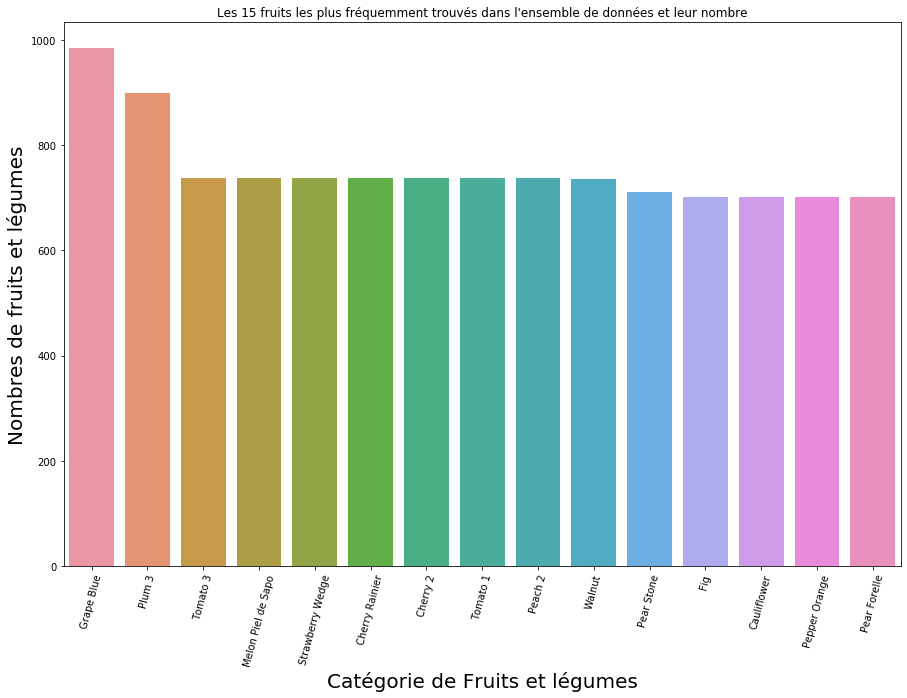

In [12]:
plt.figure(figsize=(15,10))
ax= sns.barplot(x=x, y=y) 
plt.xlabel('Catégorie de Fruits et légumes', size = 20) 
plt.ylabel('Nombres de fruits et légumes', size = 20 )
plt.xticks(rotation = 75)
plt.title("Les 15 fruits les plus fréquemment trouvés dans l'ensemble de données et leur nombre") 
plt.show()

### Visulation des catégories en images 

Largeur : 100 px, hauteur : 100 px


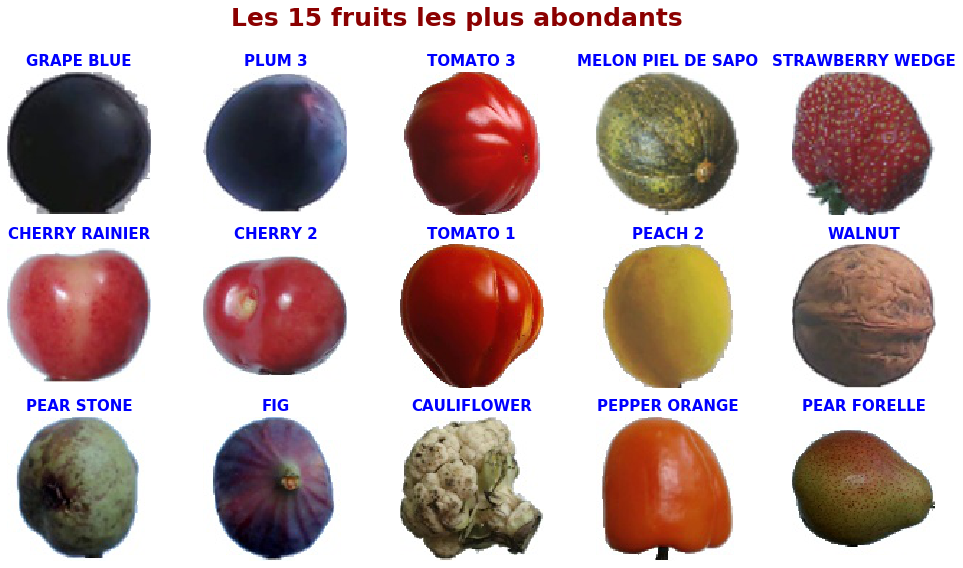

In [18]:
plt.figure(figsize=(17,9))

for i in range(len(x)):
    fruits = train_fruits[train_fruits["fruits"] == x[i]]["image"].values [1]
    
    plt.subplot(3,5,i+1)
    img = Image.open(train + fruits)
    plt.imshow(img)
    plt.title(x[i].upper(), color = "blue", fontsize = 15 , fontweight = 600)
    plt.axis("off")

plt.suptitle("Les 15 fruits les plus abondants", fontsize = 25 , color = "darkred", fontweight = 'bold')
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))
plt.show()

### Traitement d'image 

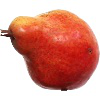

In [51]:
img = Image.open(train+listes_photos[3305])
img

In [52]:
img= cv.imread(train+listes_photos[3305])

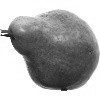

In [53]:
image_gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
Image.fromarray(image_gris)

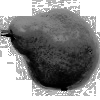

In [54]:
hist = cv.equalizeHist(image_gris)
Image.fromarray(hist)

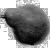

In [55]:
img_siz = cv.resize(hist, dsize=(50,50))
Image.fromarray(img_siz)

# Création de la SparkSession

Pour la preuve de concept localement (et à cause des ressources limitées), j'ai sélectionné arbitrairement 4 catégories de fruits dans le jeu de données et sélectionné à chaque fois deux images random, total = 8 images.

In [56]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate())

In [57]:
sc = spark.sparkContext
sc

<SparkContext master=local appName=P8>

In [58]:
# Définition des path
PATH = '../Projet_8/'
PATH_df = PATH + 'data/fruit_1'
PATH_resultat = PATH+ 'data/resultat'

## Chargement des données 

Nous allons charger les images au format binaire présent depuis Spark 3.0, il permet de lire (image, pdf, zip, gzip, tar, etc.) DataFrameReader convertit tout le contenu de chaque fichier binaire en un seul DataFrame, le DataFrame résultant contient le contenu brut et les métadonnées du fichier. 

l'option pathglobalFilter en jpg permet de lire tous les fichier jpg à partie du chemin avec tous les répertoires partitionnés.
+ recursive permet de charger tous les objets possibles contenus dans les sous-dossiers du dossier sélectionné 

In [59]:
image_df = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true").load(PATH_df)
print(image_df.printSchema())

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

None


In [60]:
image_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/Users/vince...|2021-09-12 19:26:20|  4432|[FF D8 FF E0 00 1...|
|file:/Users/vince...|2021-09-12 19:26:20|  4417|[FF D8 FF E0 00 1...|
|file:/Users/vince...|2021-09-12 19:26:16|  4242|[FF D8 FF E0 00 1...|
|file:/Users/vince...|2021-09-12 19:26:16|  4242|[FF D8 FF E0 00 1...|
|file:/Users/vince...|2021-09-12 19:26:08|  3974|[FF D8 FF E0 00 1...|
|file:/Users/vince...|2021-09-12 19:26:08|  3932|[FF D8 FF E0 00 1...|
|file:/Users/vince...|2021-09-12 19:25:56|  3643|[FF D8 FF E0 00 1...|
|file:/Users/vince...|2021-09-12 19:25:56|  3574|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+



Nous voulons garder le path, le content des fichiers puis de rajouter les labels des fruits ainsi que le nom du fichier jpg associé à l'image 

In [61]:
def get_folder_name(path):
    #Returns fruit folder name
    ls_files = path.split('/')
    fruit = ls_files[-2] #folder name
    return fruit

In [62]:
udf_fruits = udf(get_folder_name, StringType())
image_df = image_df.withColumn('label', udf_fruits('PATH'))
image_df = image_df.withColumn('image', split(col('PATH'), '/').getItem(9))
image_df = image_df.select('PATH', 'content', 'label', 'image')
image_df.show(8)

+--------------------+--------------------+------+----------+
|                PATH|             content| label|     image|
+--------------------+--------------------+------+----------+
|file:/Users/vince...|[FF D8 FF E0 00 1...| Lemon| 1_100.jpg|
|file:/Users/vince...|[FF D8 FF E0 00 1...| Lemon| 0_100.jpg|
|file:/Users/vince...|[FF D8 FF E0 00 1...|  Kaki|12_100.jpg|
|file:/Users/vince...|[FF D8 FF E0 00 1...|  Kaki|14_100.jpg|
|file:/Users/vince...|[FF D8 FF E0 00 1...|  Corn| 1_100.jpg|
|file:/Users/vince...|[FF D8 FF E0 00 1...|  Corn| 0_100.jpg|
|file:/Users/vince...|[FF D8 FF E0 00 1...|Banana| 0_100.jpg|
|file:/Users/vince...|[FF D8 FF E0 00 1...|Banana| 1_100.jpg|
+--------------------+--------------------+------+----------+



### Transformation d'une image binaire en vecteur 

In [63]:
df = spark.read.format("image").load("/Users/vincentMalfroy/Desktop/OpenClassrooms/Projet_8/data/fruit_1/Lemon")
df.show()

ImageSchema.imageFields

img2vec = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x).flatten()), VectorUDT())

df = df.withColumn('vecs', img2vec("image"))
df.show()

+--------------------+
|               image|
+--------------------+
|{file:///Users/vi...|
|{file:///Users/vi...|
+--------------------+



+--------------------+--------------------+
|               image|                vecs|
+--------------------+--------------------+
|{file:///Users/vi...|[255.0,255.0,255....|
|{file:///Users/vi...|[255.0,255.0,255....|
+--------------------+--------------------+



## Préparation du modèle

### Transfer-learning

Je vais utiliser la technique du transfert learning pour extraire les features des images.

Pour ce faire, nous allons utiliser le modèle ResNet50

Resnet50 est utilisé pour désigner la variante qui peut fonctionner avec 50 couches de réseau de neurones. Il a une précision accrue par rapport à d'autres modèles tels que ResNet-34 ou bien encore VGG-16 et un temps de formation réduit.

Dans ce modèle, il existe une dernière couche qui permet de classer les images parmi 1000 catégories d'objets, mais pour notre objectif présent nous ne souhaitons pas utiliser cette dernière couche. De ce fait, nous allons récupérer le vecteur (1,1,2048)

Resnet 50 prend en entrer des images de dimension (224,224,3), nos images ne sont pas à ces dimensions. De ce fait, nous devons les redimensionner pour qu'elles correspondent au modèle. 

In [26]:
model = ResNet50(include_top=False,
                weights=None,
                pooling='max',
                input_shape=(224,224,3),
                )
model.summary()

2022-02-08 15:02:15.998296: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 15:02:15.998660: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Les workeurs Spark doivent accéder au modèle et à ses poids.

Pour les modèles de taille moyenne (taille < 1 Go), une bonne pratique consiste à télécharger le modèle sur le pilote Spark (noeud maitre), puis à diffuser les pondérations aux travailleurs. 

Modèle sur un noeud (worker) on peut déjà copier les poids dans différents workeur pas de communication entre ceux qui ont et ceux qui n'ont pas traité independant sans faire une communication = permet accélérer le calcule 

In [27]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights()) 

## Fonction
Les fonctions qui suivent sont repris de ce site web 
https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html

+ Notre modèle de transfer-learning

In [28]:
def model_fn():
    
    model = ResNet50(include_top=False,
                weights=None,
                pooling='max',
                input_shape=(224,224,3)) 
    model.set_weights(bc_model_weights.value)
    return model

+ Preprocessing

In [29]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) 

+ Prédiction du modèle donnat des features en sortie

In [30]:
def featurize_series(model, content_series):
    
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

+ Rassemblement en utilisant Pandas_udf sur notre fonction spark

In [31]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/vincentMalfroy/opt/anaconda3/envs/pyspark_env/lib/python3.7/site-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


## Application des divers fonction pour l'extraction de features 

In [32]:
features_df = image_df.select(col("PATH"), col("label"), featurize_udf("content").alias("vecs"))
features_df.printSchema()
features_df.show()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- vecs: array (nullable = true)
 |    |-- element: float (containsNull = true)



2022-02-08 15:02:26.066118: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 15:02:26.067961: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


+--------------------+------+--------------------+
|                path| label|                vecs|
+--------------------+------+--------------------+
|file:/Users/vince...| Lemon|[2.4437063, 7.665...|
|file:/Users/vince...| Lemon|[2.4568324, 7.883...|
|file:/Users/vince...|  Kaki|[2.5760984, 10.72...|
|file:/Users/vince...|  Kaki|[2.4961286, 10.97...|
|file:/Users/vince...|  Corn|[3.3957891, 7.723...|
|file:/Users/vince...|  Corn|[3.364577, 7.4813...|
|file:/Users/vince...|Banana|[3.6769335, 8.368...|
|file:/Users/vince...|Banana|[3.5862331, 8.436...|
+--------------------+------+--------------------+



Nous avons deux solutions pour sauvegarder notre vecteur soit au format CSV soit au format parquet
#features_df.write.mode("overwrite").csv(path_resultat)
Nous allons nous diriger vers le format parquet pour ses avantages :
    + il ignore très rapidement les données non-pertinentes, ce qui accélère l'exécution des requêtes.
    + Il réduit également le stockage des données de 75 % en moyenne

In [33]:
features_df.write.mode("overwrite").parquet(PATH_resultat)

2022-02-08 15:46:07.977110: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 15:46:07.978335: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [34]:
df = pd.read_parquet(PATH_resultat, engine='pyarrow')

In [37]:
df.head(8)

path   label  \
0  file:/Users/vincentMalfroy/Desktop/OpenClassro...   Lemon   
1  file:/Users/vincentMalfroy/Desktop/OpenClassro...   Lemon   
2  file:/Users/vincentMalfroy/Desktop/OpenClassro...    Kaki   
3  file:/Users/vincentMalfroy/Desktop/OpenClassro...    Kaki   
4  file:/Users/vincentMalfroy/Desktop/OpenClassro...    Corn   
5  file:/Users/vincentMalfroy/Desktop/OpenClassro...    Corn   
6  file:/Users/vincentMalfroy/Desktop/OpenClassro...  Banana   
7  file:/Users/vincentMalfroy/Desktop/OpenClassro...  Banana   

                                                vecs  
0  [2.4437063, 7.665549, 8.509123, 12.955517, 13....  
1  [2.4568324, 7.883995, 8.250756, 12.4706, 13.37...  
2  [2.5760984, 10.720467, 12.461779, 12.679739, 1...  
3  [2.4961286, 10.9721155, 12.228958, 12.776669, ...  
4  [3.3957891, 7.723899, 9.197212, 13.905402, 12....  
5  [3.364577, 7.4813776, 9.082962, 13.832715, 13....  
6  [3.6769335, 8.368406, 9.535542, 14.848761, 14....  
7  [3.5862331, 8.436393, 9.3003645, 14.745042, 13...

In [38]:
print("La taille du vecteur:", df.loc[1,'vecs'].shape)

La taille du vecteur: (2048,)
